In [1]:
!nvidia-smi

Thu Apr 13 06:04:16 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   58C    P8    10W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
import torch
print(torch.cuda.is_available())

True


In [3]:
!pip install pynvml

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 3.0 MB/s eta 0:00:00


In [4]:
import os
os.environ['PATH'] += ':/usr/local/cuda/bin'

In [5]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.optim.lr_scheduler as lr_scheduler
from torch.optim.lr_scheduler import _LRScheduler
import torch.utils.data as data

import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torchvision.models as models

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
from collections import namedtuple
import os
import random
import shutil
import time

In [6]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [11]:
ROOT = "/content/drive/MyDrive/Colab Notebooks/AI_PROJECT/Dataset1_Customised"

In [16]:
data_dir = ROOT
train_dir = "/content/drive/MyDrive/Colab Notebooks/AI_PROJECT/Dataset1_Customised/train"
test_dir = "/content/drive/MyDrive/Colab Notebooks/AI_PROJECT/Dataset1_Customised/test"

In [56]:
train_data = datasets.ImageFolder(root = train_dir, transform = transforms.ToTensor())

means = torch.zeros(3)
stds = torch.zeros(3)

for img, label in train_data:
    means += torch.mean(img, dim = (1,2))
    stds += torch.std(img, dim = (1,2))

means /= len(train_data)
stds /= len(train_data)
    
print(f'Calculated means: {means}')
print(f'Calculated stds: {stds}')

Calculated means: tensor([0.4936, 0.4809, 0.4205])
Calculated stds: tensor([0.1958, 0.1959, 0.2013])


In [18]:
pretrained_size = 224
pretrained_means = [0.4936, 0.4809, 0.4205]
pretrained_stds= [0.1958, 0.1959, 0.2013]

train_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.RandomRotation(5),
                           transforms.RandomHorizontalFlip(0.5),
                           transforms.RandomCrop(pretrained_size, padding = 10),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

test_transforms = transforms.Compose([
                           transforms.Resize(pretrained_size),
                           transforms.CenterCrop(pretrained_size),
                           transforms.ToTensor(),
                           transforms.Normalize(mean = pretrained_means, 
                                                std = pretrained_stds)
                       ])

In [19]:
train_data = datasets.ImageFolder(root = train_dir, 
                                  transform = train_transforms)

test_data = datasets.ImageFolder(root = test_dir, 
                                 transform = test_transforms)

In [20]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, 
                                           [n_train_examples, n_valid_examples])

In [21]:
valid_data = copy.deepcopy(valid_data)
valid_data.dataset.transform = test_transforms

In [22]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 5622
Number of validation examples: 625
Number of testing examples: 150


In [23]:
BATCH_SIZE = 32

train_iterator = data.DataLoader(train_data, 
                                 shuffle = True, 
                                 batch_size = BATCH_SIZE)

valid_iterator = data.DataLoader(valid_data, 
                                 batch_size = BATCH_SIZE)

test_iterator = data.DataLoader(test_data, 
                                batch_size = BATCH_SIZE)

In [24]:
def normalize_image(image):
    image_min = image.min()
    image_max = image.max()
    image.clamp_(min = image_min, max = image_max)
    image.add_(-image_min).div_(image_max - image_min + 1e-5)
    return image 

In [25]:
def plot_images(images, labels, classes, normalize = True):

    n_images = len(images)

    rows = int(np.sqrt(n_images))
    cols = int(np.sqrt(n_images))

    fig = plt.figure(figsize = (15, 15))

    for i in range(rows*cols):

        ax = fig.add_subplot(rows, cols, i+1)
        
        image = images[i]

        if normalize:
            image = normalize_image(image)

        ax.imshow(image.permute(1, 2, 0).cpu().numpy())
        
        label = classes[labels[i]]
        ax.set_title(label)
        ax.axis('off')

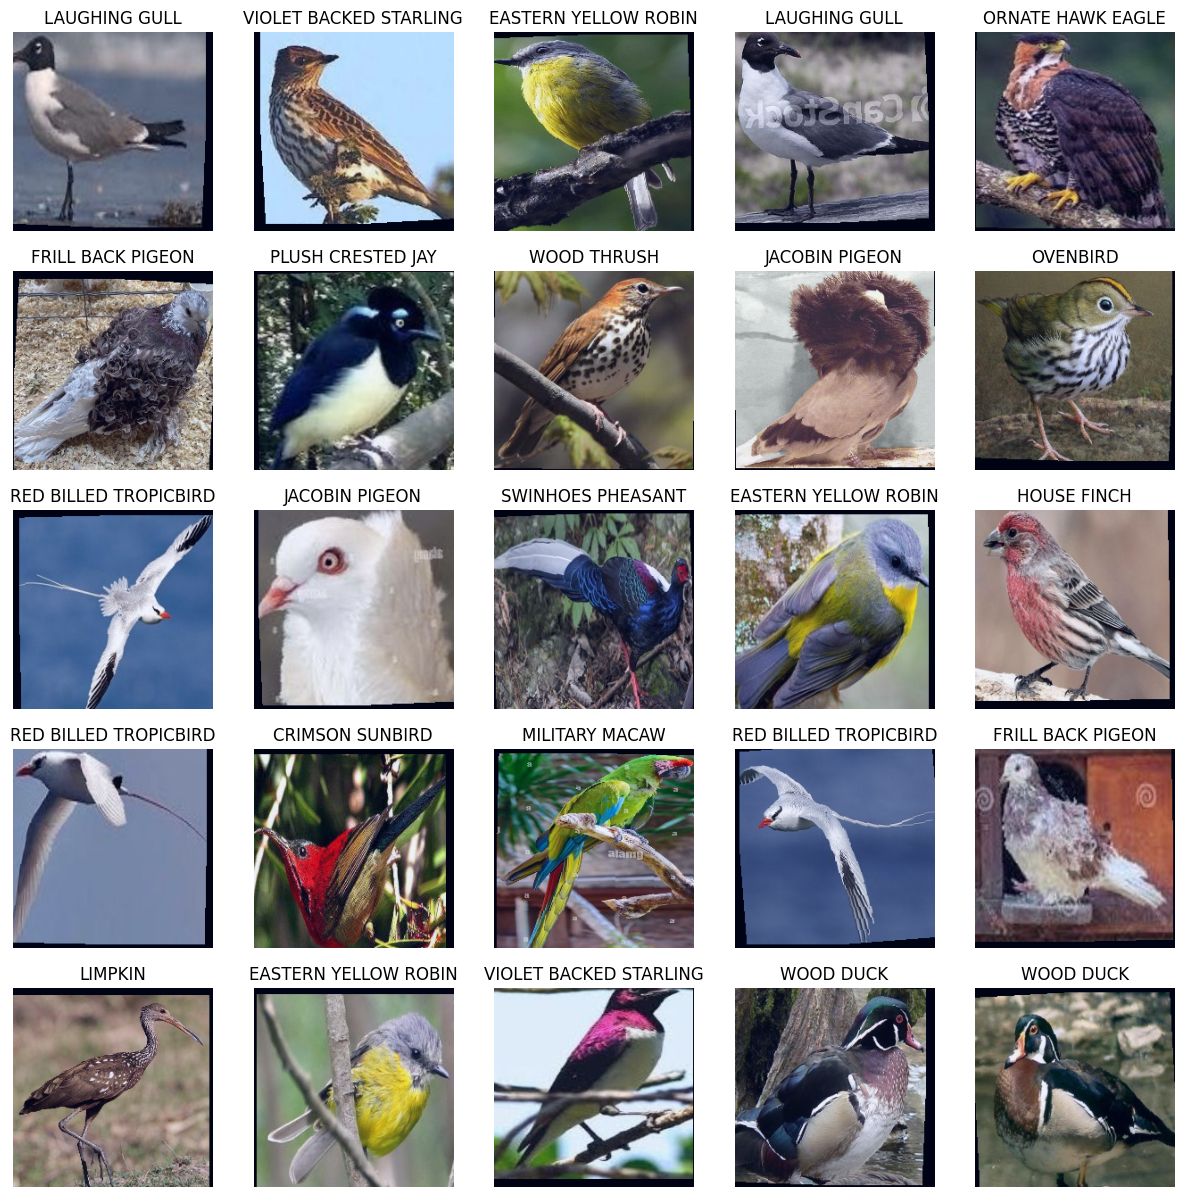

In [26]:
N_IMAGES = 25

images, labels = zip(*[(image, label) for image, label in 
                           [train_data[i] for i in range(N_IMAGES)]])

classes = test_data.classes

plot_images(images, labels, classes)

In [27]:
def format_label(label):
    label = label.split('.')[-1]
    label = label.replace('_', ' ')
    label = label.title()
    label = label.replace(' ', '')
    return label

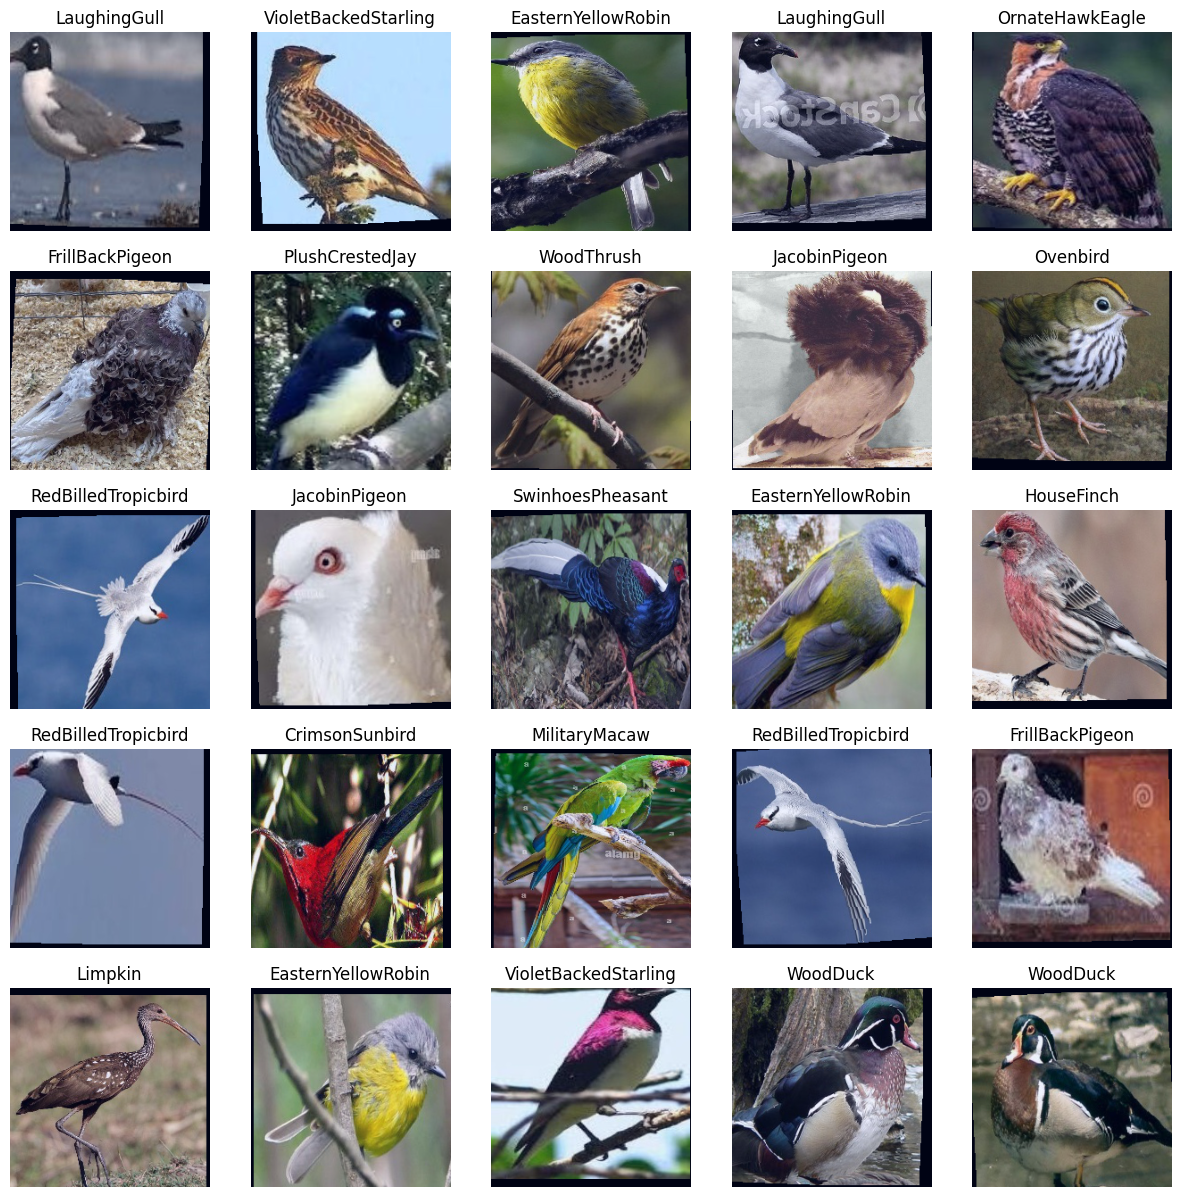

In [28]:
test_data.classes = [format_label(c) for c in test_data.classes]

classes = test_data.classes

plot_images(images, labels, classes)

In [29]:
num_classes = 30

In [30]:
import torchvision.models as models

# Load the pre-trained MobileNet model
model = torch.hub.load('pytorch/vision', 'mobilenet_v2', pretrained=False)

Downloading: "https://github.com/pytorch/vision/zipball/main" to /root/.cache/torch/hub/main.zip
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


In [31]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 3,504,872 trainable parameters


In [32]:
import os
import torch

# Create a new directory
save_dir = "/RiddhiBhuva/AI_Project/Mobilenet_Datasets"
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [33]:
# Save the state dictionary of the Mobilenet model
torch.save(model.state_dict(), os.path.join(save_dir, 'mobilenet1.pth'))

In [34]:
lr = 0.001

optimizer = optim.Adam(model.parameters(), lr = lr)
criterion = torch.nn.CrossEntropyLoss()

In [35]:
EPOCHS = 10
STEPS_PER_EPOCH = len(train_iterator)
TOTAL_STEPS = EPOCHS * STEPS_PER_EPOCH

MAX_LRS = [p['lr'] for p in optimizer.param_groups]

scheduler = lr_scheduler.OneCycleLR(optimizer,
                                    max_lr = MAX_LRS,
                                    total_steps = TOTAL_STEPS)

In [36]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

In [37]:
!pip install wandb

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 55.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 184.3/184.3 kB 25.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.2/199.2 kB 27.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 9.3 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8807 sha256=c35eeaf5ace1bae4b9a8ef13f971e92574e367f38e829b3a4724564aed4fa873
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built pathtools


In [38]:
import wandb
wandb.login()

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [39]:
run_name = 'Mobilenet-Dataset3' 
wandb.init(project="AIProject2023", name = run_name, reinit=True) #mode="disabled", id='" ", resume="must"

wandb: Currently logged in as: riddhivinodbhuva (riddhibhuva). Use `wandb login --relogin` to force relogin


In [40]:
import time

train_losses = []
train_acc_list = []
valid_losses = []
valid_acc_list = []

num_epochs = 10
best_valid_loss = float('inf')

for epoch in range(num_epochs):
    start_time = time.time()
    train_loss = 0.0
    valid_loss = 0.0
    train_correct = 0
    valid_correct = 0
    train_total = 0
    valid_total = 0
    
    # Training loop
    model.train()
    for images, labels in train_iterator:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * images.size(0)
        #print(" Loss ", loss)
        #print(" Item ", loss.item())
        #print(" Train Loss ", train_loss)
        #print(" Divided", train_loss / images.size(0))
        wandb.log({'train_loss': loss.item()})
        _, predicted = torch.max(outputs.data, 1)
        train_correct += (predicted == labels).sum().item()
        train_total += labels.size(0)
    
    # Validation loop
    model.eval()
    with torch.no_grad():
        for images, labels in valid_iterator:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            valid_loss += loss.item() * images.size(0)
            wandb.log({'valid_loss': loss.item()})
            _, predicted = torch.max(outputs.data, 1)
            valid_correct += (predicted == labels).sum().item()
            valid_total += labels.size(0)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), run_name)

    # Calculate metrics
    train_loss = train_loss / len(train_iterator.dataset)
    valid_loss = valid_loss / len(valid_iterator.dataset)
    train_accuracy = 100 * train_correct / train_total
    valid_accuracy = 100 * valid_correct / valid_total
    

    wandb.log({'train_accuracy': train_accuracy})
    wandb.log({'valid_accuracy': valid_accuracy})
    
    #append values
    
    train_losses.append(train_loss)
    train_acc_list.append(train_accuracy)
    valid_losses.append(valid_loss)
    valid_acc_list.append(valid_accuracy)
   
    
    # Print metrics
    end_time = time.time()
    epoch_time = end_time - start_time
    print(f"Epoch {epoch+1} took {epoch_time // 60:.0f}m {epoch_time % 60:.0f}s")
    print(f"Train Loss: {train_loss:.6f} | Train Accuracy: {train_accuracy:.2f}%")
    print(f"Val Loss: {valid_loss:.6f} | Val Accuracy: {valid_accuracy:.2f}%")

Epoch 1 took 41m 44s
Train Loss: 4.726905 | Train Accuracy: 4.86%
Val Loss: 3.515176 | Val Accuracy: 6.08%
Epoch 2 took 0m 50s
Train Loss: 3.355445 | Train Accuracy: 8.20%
Val Loss: 3.250398 | Val Accuracy: 6.24%
Epoch 3 took 0m 49s
Train Loss: 3.162359 | Train Accuracy: 10.16%
Val Loss: 3.110876 | Val Accuracy: 9.60%
Epoch 4 took 0m 50s
Train Loss: 3.030120 | Train Accuracy: 13.07%
Val Loss: 2.981590 | Val Accuracy: 14.40%
Epoch 5 took 0m 50s
Train Loss: 2.897447 | Train Accuracy: 17.06%
Val Loss: 2.833951 | Val Accuracy: 16.48%
Epoch 6 took 0m 49s
Train Loss: 2.766486 | Train Accuracy: 20.37%
Val Loss: 2.665138 | Val Accuracy: 24.80%
Epoch 7 took 0m 49s
Train Loss: 2.653636 | Train Accuracy: 24.56%
Val Loss: 2.560017 | Val Accuracy: 28.16%
Epoch 8 took 0m 49s
Train Loss: 2.535598 | Train Accuracy: 27.16%
Val Loss: 2.407273 | Val Accuracy: 31.84%
Epoch 9 took 0m 49s
Train Loss: 2.413461 | Train Accuracy: 30.84%
Val Loss: 2.275178 | Val Accuracy: 34.72%
Epoch 10 took 0m 49s
Train Loss:

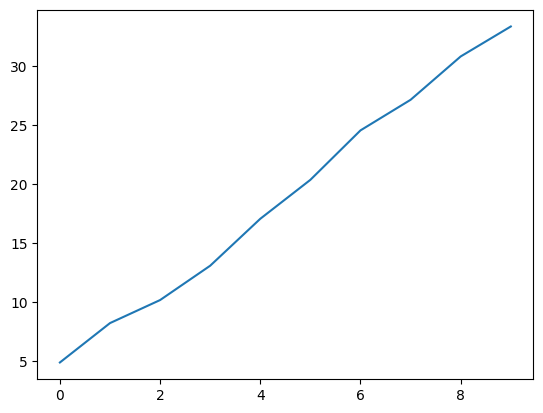

In [41]:
import matplotlib.pyplot as plt
plt.plot(np.arange(len(train_acc_list)), train_acc_list)

In [42]:
torch.save(model.state_dict(), os.path.join(save_dir, run_name + '.pth'))

In [43]:
# Testing loop
model.eval()
with torch.no_grad():
    total_test_loss = 0
    total_test_accuracy = 0
    total_test_count = 0
    for images, labels in test_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_test_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_test_accuracy += (predicted == labels).sum().item()
        total_test_count += images.size(0)

    average_test_loss = total_test_loss / total_test_count
    average_test_accuracy = total_test_accuracy / total_test_count

print(f"Test Loss: {average_test_loss:.4f}, Test Accuracy: {average_test_accuracy:.4f}")

Test Loss: 2.1932, Test Accuracy: 0.3267


In [44]:
# Evaluation loop
model.eval()
with torch.no_grad():
    total_val_loss = 0
    total_val_accuracy = 0
    total_val_count = 0
    for images, labels in valid_iterator:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        total_val_loss += loss.item() * images.size(0)
        _, predicted = torch.max(outputs.data, 1)
        total_val_accuracy += (predicted == labels).sum().item()
        total_val_count += images.size(0)

    average_val_loss = total_val_loss / total_val_count
    average_val_accuracy = total_val_accuracy / total_val_count

print(f"Validation Loss: {average_val_loss:.4f}, Validation Accuracy: {average_val_accuracy:.4f}")

Validation Loss: 2.1641, Validation Accuracy: 0.3760


In [45]:
def get_predictions(model, iterator):
    model.eval()
    images = []
    labels = []
    probs = []

    with torch.no_grad():
        for (x, y) in iterator:
            x = x.to(device)
            y = y.to(device)

            y_pred = model(x)

            y_prob = F.softmax(y_pred, dim=-1)
            top_pred = y_prob.argmax(1, keepdim=True)

            images.append(x.cpu())
            labels.append(y.cpu())
            probs.append(y_prob.cpu())

    images = torch.cat(images, dim=0)
    labels = torch.cat(labels, dim=0)
    probs = torch.cat(probs, dim=0)

    return images, labels, probs

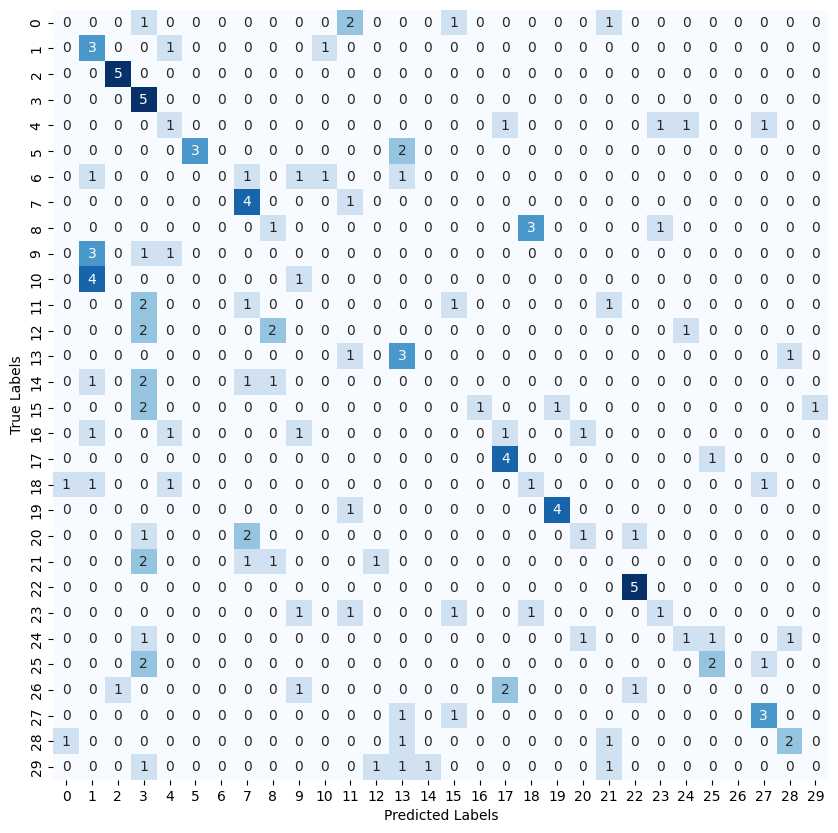

In [46]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Get predictions
images, labels, probs = get_predictions(model, test_iterator)

# Get predicted labels
pred_labels = torch.argmax(probs, 1)

# Create confusion matrix
conf_mat = confusion_matrix(labels.view(-1), pred_labels.view(-1))

# Plot confusion matrix
plt.figure(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

In [47]:
from sklearn.metrics import classification_report

# Assuming you have defined 'labels', 'pred_labels' and 'classes' variables
print(classification_report(labels, pred_labels, target_names=classes))

                       precision    recall  f1-score   support

         CampoFlicker       0.00      0.00      0.00         5
          CaspianTern       0.21      0.60      0.32         5
       CrimsonSunbird       0.83      1.00      0.91         5
      D-ArnaudsBarbet       0.23      1.00      0.37         5
        DarkEyedJunco       0.20      0.20      0.20         5
   EasternYellowRobin       1.00      0.60      0.75         5
      FrillBackPigeon       0.00      0.00      0.00         5
GreaterPrairieChicken       0.40      0.80      0.53         5
           HouseFinch       0.20      0.20      0.20         5
        JacobinPigeon       0.00      0.00      0.00         5
         LaughingGull       0.00      0.00      0.00         5
              Limpkin       0.00      0.00      0.00         5
               Merlin       0.00      0.00      0.00         5
        MilitaryMacaw       0.33      0.60      0.43         5
      OrnateHawkEagle       0.00      0.00      0.00  

/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.9/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [48]:
from sklearn.decomposition import PCA

In [49]:
# Define a function to extract features from a given layer of the model
def extract_features(model, layer, dataloader):
    model.eval()
    features = []
    with torch.no_grad():
        for images, _ in dataloader:
            outputs = model(images)
            features.append(outputs.detach().numpy())
    features = np.vstack(features)
    return features

In [50]:
# Define the layer to extract features from
layer = model.classifier[1]

In [51]:
# Set the device to run the model on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [52]:
model = model.cpu()

In [53]:
# Extract the features from the last layer of the model
features = extract_features(model, layer, test_iterator)

# Perform PCA on the features
n_components = 2  # number of principal components to keep
pca = PCA(n_components)
pca_weights = pca.fit_transform(features)

# Print the explained variance of each principal component
print(pca.explained_variance_ratio_)   

[0.9084464  0.03688812]


In [54]:
test_labels = []
for images, labels in test_iterator:
    # append the labels to the test_labels list
    test_labels.extend(labels.numpy())

# Convert the test_labels to a numpy array
test_labels = np.array(test_labels)

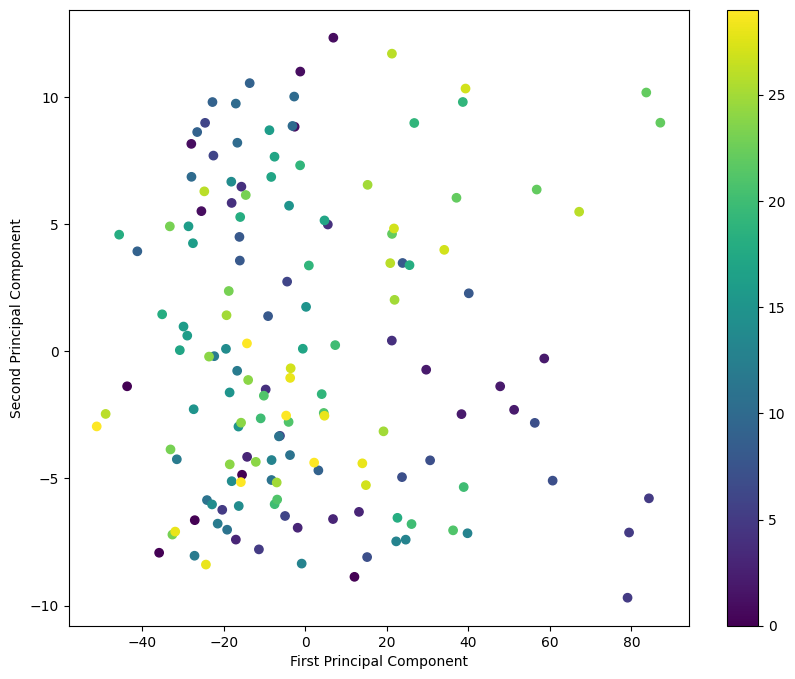

In [55]:
import matplotlib.pyplot as plt

# Plot the PCA graph
plt.figure(figsize=(10, 8))
plt.scatter(pca_weights[:, 0], pca_weights[:, 1], c=test_labels, cmap='viridis')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.colorbar()
plt.show()
